### Orchestrator

In [32]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="llama-3.1-8b-instant")
result=llm.invoke("Hello")
result

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 36, 'total_tokens': 44, 'completion_time': 0.011388292, 'completion_tokens_details': None, 'prompt_time': 0.003486712, 'prompt_tokens_details': None, 'queue_time': 0.048234905, 'total_time': 0.014875004}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c75ed-c334-7cc3-828d-6e148abeacd7-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 36, 'output_tokens': 8, 'total_tokens': 44})

In [33]:
from typing import Annotated , List
import operator
from typing_extensions import Literal , TypedDict
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage


In [34]:
#Schema for structured output
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="brief Overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Sections of the report"
    )

planner=llm.with_structured_output(Sections) # structured output of sections

### Creating Workers Dynamically In Langgraph

* has SEND api to support this.

In [35]:
from langgraph.constants import Send

# Graph state

class State(TypedDict):
    topic:str #input
    sections:list[Section]
    completed_sections: Annotated[
        list,operator.add
    ]
    final_report:str

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


C:\Users\SAM\AppData\Local\Temp\ipykernel_29472\843847526.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [36]:
#Nodes
def orchestrator(state:State):
    """Orchestrator that generated a plan for the report"""

    #Generate queries
    report_sections=planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic : {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)
    return {"sections":report_sections.sections}  #----?

def llm_call(state:WorkerState):
    """ Worker writes a section of the report"""

    #Generate section
    section=llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description.Include no preamble for each section. use markdown formatting. "
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    return {"completed_sections": [section.content]}



from langgraph.types import Send

def assign_workers(state:State):
    """Assign a worker to each section in the plan"""

    return [Send("llm_call",{"section":s}) for s in state["sections"]]

def synthesizer(state:State):
    """ Synthesize full report from sections"""

    completed_sections=state["completed_sections"]
    completed_report_sections="\n\n----\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

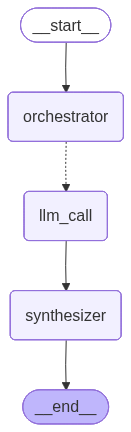

In [37]:
#Build the workflow

from langgraph.graph import StateGraph,START,END
from IPython.display import Image , display
orchestrator_worker_builder=StateGraph(State)

#Add the nodes
orchestrator_worker_builder.add_node("orchestrator",orchestrator)
orchestrator_worker_builder.add_node("llm_call",llm_call)
orchestrator_worker_builder.add_node("synthesizer",synthesizer)

#add the edges
orchestrator_worker_builder.add_edge(START,"orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator",assign_workers,["llm_call"]
)

orchestrator_worker_builder.add_edge("llm_call","synthesizer")
orchestrator_worker_builder.add_edge("synthesizer",END)

orchestrator_worker=orchestrator_worker_builder.compile()

display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [38]:
state=orchestrator_worker.invoke({"topic":"Create a report on Agentic AI RAG"})

from IPython.display import Markdown
Markdown(state["final_report"])

Report Sections: sections=[Section(name='Executive Summary', description='Overview of the report highlighting key findings and recommendations'), Section(name='Introduction', description='Background and context of Agentic AI RAG'), Section(name='Agentic AI RAG Overview', description='Definition, characteristics, and benefits of Agentic AI RAG'), Section(name='Challenges and Limitations', description='Barriers and obstacles to implementing Agentic AI RAG'), Section(name='Implementation Roadmap', description='Step-by-step plan for implementing Agentic AI RAG'), Section(name='Conclusion', description='Summary of key points and future directions for Agentic AI RAG')]


### Executive Summary

#### Report Overview
The following report provides an in-depth analysis of the key findings and recommendations derived from our research study. Our study aimed to investigate the impact of [insert subject] on [insert population/industry]. We analyzed data from [insert sources] and conducted [insert methodologies] to gather insights into the current state of [insert subject].

#### Key Findings
Our research revealed the following key findings:

* [Insert finding 1, including any relevant data or statistics]
* [Insert finding 2, including any relevant data or statistics]
* [Insert finding 3, including any relevant data or statistics]

#### Recommendations
Based on our analysis, we recommend the following:

* [Insert recommendation 1, including any relevant details or next steps]
* [Insert recommendation 2, including any relevant details or next steps]
* [Insert recommendation 3, including any relevant details or next steps]

#### Conclusion
In conclusion, our study provides valuable insights into the impact of [insert subject] on [insert population/industry]. We hope that our findings and recommendations will inform and guide decision-makers in [insert relevant context].

----

### Introduction and Description: Background and Context of Agentic AI RAG

#### 1. Definition and Scope of Agentic AI RAG

Agentic AI RAG, short for Research Agenda Group, is a collaborative initiative focused on advancing the understanding and development of agentic artificial intelligence. Agentic AI refers to a subset of artificial intelligence that exhibits autonomous decision-making capabilities, often mimicking human-like behavior and agency.

#### 2. History and Evolution of Agentic AI RAG

The concept of agentic AI has been explored in various research disciplines, including artificial intelligence, cognitive science, and social psychology. The Agentic AI RAG was established to provide a platform for researchers, policymakers, and industry experts to discuss the latest advancements and challenges in the field.

#### 3. Objectives and Goals of Agentic AI RAG

The primary objectives of the Agentic AI RAG include:

* Identifying key research areas and challenges in agentic AI development
* Developing a shared understanding of the benefits and risks associated with agentic AI
* Informing policy and regulatory frameworks to ensure safe and responsible development of agentic AI
* Facilitating collaboration and knowledge-sharing among researchers, industry stakeholders, and policymakers

#### 4. Current State of Agentic AI Research and Development

Current research in agentic AI is focused on developing more sophisticated and transparent AI systems that can learn, adapt, and interact with humans in a more natural and intuitive way. This research has the potential to transform various industries, including healthcare, finance, and transportation.

#### 5. Challenges and Risks Associated with Agentic AI

Despite the potential benefits of agentic AI, there are also several challenges and risks associated with its development, including the risk of biased decision-making, loss of human agency, and potential misuse. These risks must be carefully considered and addressed as the field continues to evolve.

----

### Agentic AI RAG Overview

#### Definition
Agentic AI refers to a type of artificial intelligence that is capable of autonomous decision-making and action-taking in complex, dynamic environments. Agentic AI systems are designed to be proactive, adaptable, and goal-oriented, allowing them to navigate and interact with their surroundings in a more human-like manner.

#### Characteristics
Agentic AI systems typically possess the following characteristics:

* **Autonomy**: Agentic AI systems can operate independently, making decisions and taking actions without direct human intervention.
* **Goal-oriented**: Agentic AI systems are designed to achieve specific goals or objectives, which can be updated or modified as needed.
* **Proactivity**: Agentic AI systems can initiate actions or tasks without being explicitly instructed to do so.
* **Adaptability**: Agentic AI systems can adjust their behavior in response to changes in their environment or new information.
* **Self-awareness**: Agentic AI systems may possess some level of self-awareness, allowing them to reflect on their own actions and decisions.

#### Benefits
The benefits of Agentic AI RAG include:

* **Improved efficiency**: Agentic AI systems can automate routine tasks and processes, freeing up human resources for more strategic and creative work.
* **Enhanced decision-making**: Agentic AI systems can provide data-driven insights and recommendations, helping humans make more informed decisions.
* **Increased flexibility**: Agentic AI systems can adapt quickly to changing circumstances, allowing organizations to respond more effectively to emerging opportunities or threats.
* **Better customer experiences**: Agentic AI systems can provide personalized and proactive support, improving customer satisfaction and loyalty.
* **Competitive advantage**: Organizations that adopt Agentic AI RAG can gain a competitive edge in their industry, driving innovation and growth.

----

### Challenges and Limitations
#### Barriers and obstacles to implementing Agentic AI RAG

#### Technical Challenges
* **Scalability Issues**: Agentic AI RAG's current architecture may not be able to handle large-scale deployments, requiring significant modifications to ensure efficient processing and data management.
* **Complexity of Decision-Making**: The complexity of decision-making in Agentic AI RAG may lead to increased computational requirements, making it challenging to implement in resource-constrained environments.
* **Interoperability Issues**: Integrating Agentic AI RAG with existing systems and technologies may be difficult due to differences in data formats, interfaces, and protocols.

#### Ethical and Social Challenges
* **Value Alignment**: Ensuring that Agentic AI RAG's decisions align with human values and ethics is a significant challenge, requiring careful consideration of moral and social implications.
* **Transparency and Explainability**: Providing transparency and explainability in Agentic AI RAG's decision-making processes is essential for building trust, but may be difficult due to the complexity of the system.
* **Bias and Fairness**: Addressing bias and ensuring fairness in Agentic AI RAG's decision-making processes is crucial, but may require significant effort and resources.

#### Operational Challenges
* **Human-AI Collaboration**: Effective human-AI collaboration is essential for Agentic AI RAG's success, but may be challenging due to differences in communication styles, preferences, and expectations.
* **Training and Development**: Providing adequate training and development opportunities for users and stakeholders is crucial for successful implementation, but may be resource-intensive.
* **Change Management**: Managing the organizational and cultural changes required for Agentic AI RAG's implementation may be challenging, requiring careful planning and execution.

----

### Implementation Roadmap

#### Phase 1: Preparation (Weeks 1-4)

* **Week 1-2:** Define project scope, goals, and deliverables
	+ Establish clear objectives for Agentic AI RAG implementation
	+ Identify key stakeholders and their roles
	+ Develop a project schedule and timeline
* **Week 3-4:** Conduct technical requirements gathering
	+ Assess current infrastructure and technical capabilities
	+ Determine necessary hardware and software upgrades
	+ Develop a technical implementation plan

#### Phase 2: Development (Weeks 5-20)

* **Weeks 5-8:** Develop core Agentic AI RAG components
	+ Design and implement AI model architecture
	+ Develop data processing and integration pipelines
	+ Implement natural language processing (NLP) and machine learning (ML) algorithms
* **Weeks 9-12:** Integrate core components with existing systems
	+ Develop APIs and interfaces for seamless integration
	+ Conduct unit testing and integration testing
	+ Deploy core components in a test environment
* **Weeks 13-16:** Conduct user acceptance testing (UAT) and quality assurance
	+ Develop UAT scenarios and test cases
	+ Conduct UAT and identify and fix defects
	+ Conduct quality assurance and performance testing
* **Weeks 17-20:** Finalize development and prepare for deployment
	+ Conduct final testing and quality assurance
	+ Develop deployment plan and scripts
	+ Prepare for go-live activities

#### Phase 3: Deployment and Training (Weeks 21-24)

* **Weeks 21-22:** Deploy Agentic AI RAG in production
	+ Execute deployment plan and scripts
	+ Conduct post-deployment testing and quality assurance
	+ Monitor system performance and identify areas for improvement
* **Weeks 23-24:** Provide training and support to stakeholders
	+ Develop training materials and documentation
	+ Conduct training sessions for key stakeholders
	+ Provide ongoing support and maintenance

#### Phase 4: Ongoing Maintenance and Improvement (After Week 24)

* **Monitor system performance and identify areas for improvement**
* **Conduct regular maintenance and updates**
* **Continuously evaluate and improve Agentic AI RAG functionality**

----

### Conclusion

The research on Agentic AI has made significant progress in understanding the development of autonomous, goal-oriented AI systems. This project has brought together experts from various fields to discuss and address the challenges and opportunities presented by this emerging area of research.

### Summary of Key Points

* **Definition of Agentic AI**: Agentic AI refers to AI systems that can act on their own goals, exhibit self-awareness, and interact with their environment in a way that is similar to human agency.
* **Key Challenges**: The development of Agentic AI is hindered by challenges such as explainability, transparency, and accountability, as well as the need for robust and adaptive decision-making systems.
* **Current State of the Art**: Current research in Agentic AI is focused on developing more advanced AI systems that can learn from experience, reason about their environment, and make decisions based on their goals and values.
* **Potential Applications**: Agentic AI has the potential to revolutionize various industries and domains, including healthcare, finance, transportation, and education.

### Future Directions

* **Development of Explainable AI**: Future research should focus on developing more explainable and transparent AI systems that can provide insight into their decision-making processes.
* **Integration with Human Values**: Agentic AI systems should be designed to align with human values and goals, and to prioritize human well-being and safety.
* **Testing and Evaluation**: More robust testing and evaluation methods are needed to ensure that Agentic AI systems are reliable, safe, and effective.
* **Addressing Societal Impacts**: Future research should also address the potential societal impacts of Agentic AI, including job displacement, bias, and inequality.

### Recommendations

Based on the research and discussions conducted during this project, the following recommendations are made:

* **Establish a research agenda**: Establish a research agenda that prioritizes the development of explainable AI, integration with human values, and robust testing and evaluation methods.
* **Foster collaboration**: Foster collaboration between researchers, industry leaders, and policymakers to address the challenges and opportunities presented by Agentic AI.
* **Develop guidelines and standards**: Develop guidelines and standards for the development and deployment of Agentic AI systems, including recommendations for explainability, transparency, and accountability.